# chap03 : word2vec

## 3.1 推論ベースの手法とニューラルネットワーク


### カウントベースの手法の問題点

カウントベースでのベクトル獲得<br>
単語の共起行列 &rarr; SVD &rarr; 単語の分散表現

カウントベースでは周囲の単語の頻度で単語を表現するので、コーパスが大規模になるとSVDの計算量が膨大になる(O(n^3))

推論ベースの手法ではニューラルネットワークを使い、ミニバッチ学習で重みを逐次的に学習ができる<br>
&rarr; **膨大な計算量となっても学習が可能となる**

### ニューラルネットワークにおける単語の処理方法
入力層は7、中間層は3の場合、全結合層での変換は次のようになる

In [1]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])  # 入力層(one-hot表現)
w = np.random.randn(7,3)         # 重みを７＊３の形状で作成(標準正規分布)
h = np.dot(c,w)                           #中間層の計算

print(h)

[[-0.15521967 -0.91197219 -0.87656467]]


---
## 3.2 シンプルなword2vec

### CBOWモデルでの推論
このモデルでは、コンテキストからターゲットを推測することを目的としている<br>
CBOWモデルへの入力はコンテキストで、one-hot表現の形で入力することでNNで処理する

In [2]:
# CBOWモデルの実装

import sys
sys.path.append('./samplecode') # オライリーのgithubからcloneしてきたものを使用
import numpy as np
from common.layers import MatMul

# サンプルのコンテキスト
c0 = np.array([[1,0,0,0,0,0,0]]) # you
c1 = np.array([[0,0,1,0,0,0,0]]) # goodbye

# 重み 
w_in = np.random.randn(7,3) # 中間層への変換
w_out = np.random.randn(3,7) # 出力層への変換

# レイヤ
in_layer0 = MatMul(w_in)
in_layer1 = MatMul(w_in)
out_layer = MatMul(w_out)

# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1) # 各入力層の出力の平均が中間層のニューロンとなる
s = out_layer.forward(h) # スコア(これにSoftmax関数を適用することでターゲットの確率を得る)

print(s)

[[ 0.69453365 -0.61602676  0.48633532  0.5185739  -1.67673379  1.35107565
   0.20242688]]


---
良い重みのネットワークがあれば、正確にターゲットの確率を予測することができる!<br>
CBOWモデルの学習では、**重みを調整する**

学習では、先程のネットワークのスコアに<br>
Softmax関数を適用し、確率に変換する &rarr; 交差エントロピー誤差で損失を求める<br>
(実装ではSoftmaxWithLossレイヤを使う)

---



## 3.3 学習データの準備

### コンテキストとターゲット
word2vecではターゲットが教師データ、そのコンテキスト(例では周囲1単語)が入力となる<br>
以下、コーパスからコンテキストとターゲットを作成する関数(2章で実装済み)

In [3]:
# import sys
# sys.path.append('./samplecode') # オライリーのgithubからcloneしてきたものを使用
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


---
次にコーパスからコンテキストとターゲットを作成する関数を実装する

In [4]:
def create_contexts_target(corpus, window_size=1) :
    #つまり[1:7]となる. 例の場合だと[1,2,3,4,1,5]
    target = corpus[window_size : -window_size] 
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size) : # 例だとange(1,7)
        cs = []
        for t in range(-window_size, window_size + 1) : # 例だとrange(-1,2)
            if t == 0 :
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [5]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


---
得られたコンテキストとターゲットをニューラルネットワークで利用しやすいone-hot表現へと変換する

In [6]:
# import sys
# sys.path.append('./samplecode') # オライリーのgithubからcloneしてきたものを使用
from common.util import preprocess, create_contexts_target, convert_one_hot

# コーパス、単語とIDの紐づけ
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

# コンテキストとターゲットの作成
contexts, target = create_contexts_target(corpus, window_size=1)

# one-hot表現への変換
vocab_size = len(word_to_id) # 単語数(重複なし)
target = convert_one_hot(target,vocab_size)
contexts = convert_one_hot(contexts,vocab_size)

---

## 3.4 CBOWモデルの実装

これまでの理論をもとにCBOWモデルの2層ニューラルネットワークを実装する

In [7]:
# import sys
# sys.path.append('./samplecode') # オライリーのgithubからcloneしてきたものを使用
# import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW :
    # イニシャライザ
    def __init__(self, vocab_size, hidden_size) :
        V, H = voacb_size, hidden_size
        
        # 重み(floatで作成)
        w_in = 0.01 * np.random.randn(V,H).astype('f')
        w_out = 0.01 * np.random.randn(H,V).astype('f')
        
        # レイヤの作成
        self.in_layer0 = MatMul(w_in)
        self.in_layer1 = MatMul(w_in)
        self.out_layer = MatMul(w_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], [] # []を1つにしたら浅いコピーとなる
        for layer in layers :
            self.params += layer.params
            self.grads += layer.grads
            
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = w_in
        
    # 順伝播(損失を返却)
    def forward(self, contexts, target) :
        h0 = self.in_layer0.forward(contexts[:,0]) # ターゲットの1つ前のコンテキスト
        h1 = self.in_layer1.forward(contexts[:,1]) # ターゲットの1つ後ろのコンテキスト
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score,target)
        
        return loss
    
    # 逆伝播(結果はコンストラクタが持つので、何も返却しない)
    def backward(self, dout=1) :
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        
        return None

---

### 学習コードの実装

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 228 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 229 |  iter 1 / 2 | time 0[s] | loss 1.13
| epoch 230 |  iter 1 / 2 | time 0[s] | loss 1.17
| epoch 231 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 232 |  iter 1 / 2 | time 0[s] | loss 1.30
| epoch 233 |  iter 1 / 2 | time 0[s] | loss 1.15
| epoch 234 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 235 |  iter 1 / 2 | time 0[s] | loss 1.22
| epoch 236 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 237 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 238 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 239 |  iter 1 / 2 | time 0[s] | loss 1.19
| epoch 240 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 241 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 242 |  iter 1 / 2 | time 0[s] | loss 1.17
| epoch 243 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 244 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 245 |  iter 1 / 2 | time 0[s] | loss 1.00
| epoch 246 |  iter 1 / 2 | time 0[s] | loss 1.17
| epoch 247 |  iter 1 / 2 | time 0[s] | loss 1.09


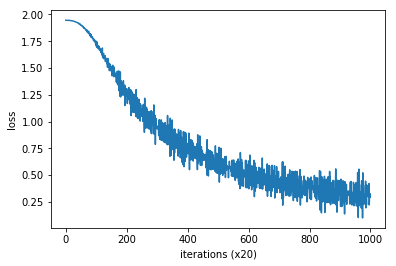

you [ 0.90615147  1.68215835 -0.87733966  1.01308501  1.06217325]
say [-0.21972851  1.20407724  0.65991694 -1.24922419 -1.24105394]
goodbye [ 0.92452365 -0.5858084  -0.98606491  1.14013183  1.08167529]
and [-1.60461271  1.13841367  1.52950132 -0.78876382 -0.74438894]
i [ 0.9025355  -0.59123462 -0.99096054  1.12820137  1.07005954]
hello [ 0.91368437  1.67715764 -0.88838565  1.03079188  1.06281865]
. [ 1.49006212  0.89250141 -1.63309455 -1.27555776 -1.28759205]


In [8]:
# import sys
# sys.path.append('./samplecode') # オライリーのgithubからcloneしてきたものを使用
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id) 
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target,vocab_size)
contexts = convert_one_hot(contexts,vocab_size)

model = SimpleCBOW(vocab_size,hidden_size) # ニューラルネットワークのモデル
optimizer = Adam() # 最適化にどのアルゴリズムを利用するか
trainer = Trainer(model, optimizer) # 学習

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 学習終了後の重みパラメータ
word_vecs  = model.word_vecs
for word_id, word in id_to_word.items() :
    print(word, word_vecs[word_id])

この重みはコーパスが小さいため良い結果とは言えない<br>
しかし大きいコーパスにすると、処理速度の問題が発生してしまう

---

## 3.5 word2vecに関する補足

word2vecでは2つのモデルが提案されている<br>
CBOW &rarr; コンテキストからターゲットを推測<br>
skip-gram &rarr; ターゲットからコンテキストを推測

精度については<br>
skip-gram > CBOW<br>
となっており、特にコーパスが大規模になるとskip-gramのほうが優れた結果が得られる傾向にある

処理速度では<br>
CBOW > skip-gram<br>
となっている